# NLP AE1
#### Student ID: 23220004

## Sentiment Analysis assignment
This assignment starts by exploring practical implementations of NER and POS on a sentiment analysis dataset. Then two sentiment analysis tasks are carried out on different datasets: Logistic Regression is used for the Amazon reviews dataset, and a bi-directional RNN with LSTM is used for the Movie reviews dataset.




## Coding Questions
NER and POS are most effective when used on full sentences rather than single-word tokens and when the punctuation and capitalisation of words is intact. Therefore, I will do the NER and POS tasks first, then clean and tokenise the data ready for sentiment analysis.

### Data
The dataset is available at: https://www.kaggle.com/code/pradeepkumar7661/sentiment-analysis-on-consumer-reviews/input

The file I will be using from this dataset is 1429_1.csv. It contains many columns with information about the product being reviewed, the actual product listing and the reviews themselves.

For my sentiment analysis, the only columns I am concerned with are "reviews.text" which contain the body text of the reviews, and "reviews.doRecommend" which shows TRUE or FALSE for whether the review recommends the product- this can be used as a sentiment label.

The text data from the "reviews.text" column is also what I will be using for the NER and POS exercises.

In [ ]:
# Import statements
# A couple of these are unused in the final version of the code but I did use
# All of them for experimenting. Seeing as this code will not be run when marked, I will
# keep all the imports in.
import pandas as pd
import spacy
import time
from datetime import timedelta
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import string
import nltk
import contractions
import re
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
nltk.download('wordnet')

2024-03-09 02:38:48.177629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-09 02:38:48.177649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package wordnet to /home/dawn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
sp = spacy.load('en_core_web_sm')

In [ ]:
# Read the relevent columns from the dataset into a DataFrame
amzn_df = pd.read_csv("1429_1.csv", usecols=["reviews.text", "reviews.doRecommend"])
amzn_df.head()

,reviews.doRecommend,reviews.text
0,True,This product so far has not disappointed. My c...
1,True,great for beginner or experienced person. Boug...
2,True,Inexpensive tablet for him to use and learn on...
3,True,I've had my Fire HD 8 two weeks now and I love...
4,True,I bought this for my grand daughter when she c...


In [ ]:
# checking how many reviews are in the dataset
len(amzn_df["reviews.text"])

34660

In [ ]:
# Change datatype of reviews.text to string to make sure spacey can process it
amzn_df["reviews.text"] = amzn_df["reviews.text"].astype(str)
amzn_df["reviews.text"].dtype

dtype('O')

In [ ]:
# Linear Regression wants my labels to be binary so I will change that
amzn_df["reviews.doRecommend"].replace(True, 1, inplace=True)
amzn_df["reviews.doRecommend"].replace(False, 0, inplace=True)

In [ ]:
amzn_df.head()

,reviews.doRecommend,reviews.text
0,1.0,This product so far has not disappointed. My c...
1,1.0,great for beginner or experienced person. Boug...
2,1.0,Inexpensive tablet for him to use and learn on...
3,1.0,I've had my Fire HD 8 two weeks now and I love...
4,1.0,I bought this for my grand daughter when she c...


### Part of Speech Tagging

As the task is to assign each review POS tags and NER labels, I will create new columns in the dataframe to hold these tags and labels so they may be easily accessed for each word in each review.

However, it would be easier to do frequency analysis on one large list of tags and one of labels, so I will also be creating those at the same time as I create the columns.

In [ ]:
# Testing how to tag every word in a review
sen = sp("This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.")
for word in sen:
    print(word.tag_)

DT
NN
RB
RB
VBZ
RB
VBN
.
PRP$
NNS
VBP
TO
VB
PRP
CC
PRP
VBP
DT
NN
TO
VB
NN
WP
NN
PRP
VBP
IN
NN
.


In [ ]:
# Initialise list to contain all pos tags (for frequency analysis)
tags = []
# Initialise list which will become the pos.tags column (to ASSIGN TAGS TO WORDS in each review)
pos_tags_column = []

# I'm keeping track of time elapsed/ entries processed because my laptop is slow
# and I like to know how long things take
count = 0
start = time.time()

#iterate through each review
for index, row in amzn_df.loc[:, ["reviews.text"]].iterrows():
    # initialise empty dict
    pos_dict = {}
    review = sp(row["reviews.text"])
    #for each word in review:
    for word in review:
        # add word and tag to dict, add tag to tags list
        pos_dict[word] = word.tag_
        tags.append(word.tag_)
    # add the dict for this review to the pos.tags column list
    pos_tags_column.append(pos_dict)
    # time & entries
    sec = time.time() - start
    count = count + 1
    if count%1000==0:
        print("Time elapsed:", (timedelta(seconds=sec)), "Entries Complete:", count)

print("Process complete.")

Time elapsed: 0:00:06.892842 Entries Complete: 1000
Time elapsed: 0:00:13.383821 Entries Complete: 2000
Time elapsed: 0:00:20.937330 Entries Complete: 3000
Time elapsed: 0:00:26.798572 Entries Complete: 4000
Time elapsed: 0:00:33.358121 Entries Complete: 5000
Time elapsed: 0:00:40.040071 Entries Complete: 6000
Time elapsed: 0:00:46.436373 Entries Complete: 7000
Time elapsed: 0:00:52.511618 Entries Complete: 8000
Time elapsed: 0:00:58.638657 Entries Complete: 9000
Time elapsed: 0:01:05.092308 Entries Complete: 10000
Time elapsed: 0:01:11.540362 Entries Complete: 11000
Time elapsed: 0:01:18.291025 Entries Complete: 12000
Time elapsed: 0:01:24.794332 Entries Complete: 13000
Time elapsed: 0:01:30.868787 Entries Complete: 14000
Time elapsed: 0:01:37.564564 Entries Complete: 15000
Time elapsed: 0:01:43.911122 Entries Complete: 16000
Time elapsed: 0:01:50.235153 Entries Complete: 17000
Time elapsed: 0:01:57.295599 Entries Complete: 18000
Time elapsed: 0:02:04.239083 Entries Complete: 19000
Ti

In [ ]:
amzn_df["pos.tags"] = pos_tags_column
amzn_df.head()

,reviews.doRecommend,reviews.text,pos.tags
0,1.0,This product so far has not disappointed. My c...,"{This: 'DT', product: 'NN', so: 'RB', far: 'RB..."
1,1.0,great for beginner or experienced person. Boug...,"{great: 'JJ', for: 'IN', beginner: 'NN', or: '..."
2,1.0,Inexpensive tablet for him to use and learn on...,"{Inexpensive: 'JJ', tablet: 'NN', for: 'IN', h..."
3,1.0,I've had my Fire HD 8 two weeks now and I love...,"{I: 'PRP', 've: 'VBP', had: 'VBN', my: 'PRP$',..."
4,1.0,I bought this for my grand daughter when she c...,"{I: 'PRP', bought: 'VBD', this: 'DT', for: 'IN..."


### Named Entity Recognition

In [ ]:
# Similar code to POS - adding a dict to assign NER labels to each review
# also making a big list for frequency analysis
ner_labels = []
ner_labels_column = []

count = 0
start = time.time()
# For each review in reviews txt
#iterate through each review
for index, row in amzn_df.loc[:, ["reviews.text"]].iterrows():
    ner_dict = {}
    review = sp(row["reviews.text"])
    #for each word in review:
    for entity in review.ents:
        # add word and tag to dict, add labels to labels list
        ner_dict[entity] = entity.label_
        ner_labels.append(entity.label_)
    # add the dict for this review to the ner.labels column list
    ner_labels_column.append(ner_dict)
    # time & entries
    sec = time.time() - start
    count = count + 1
    if count%1000==0:
        print("Time elapsed:", (timedelta(seconds=sec)), "Entries Complete:", count)

print("Process complete.")

Time elapsed: 0:00:06.725505 Entries Complete: 1000
Time elapsed: 0:00:13.220857 Entries Complete: 2000
Time elapsed: 0:00:20.537875 Entries Complete: 3000
Time elapsed: 0:00:26.306559 Entries Complete: 4000
Time elapsed: 0:00:32.846311 Entries Complete: 5000
Time elapsed: 0:00:39.561536 Entries Complete: 6000
Time elapsed: 0:00:46.036213 Entries Complete: 7000
Time elapsed: 0:00:52.153746 Entries Complete: 8000
Time elapsed: 0:00:58.493588 Entries Complete: 9000
Time elapsed: 0:01:04.855975 Entries Complete: 10000
Time elapsed: 0:01:11.121012 Entries Complete: 11000
Time elapsed: 0:01:17.776208 Entries Complete: 12000
Time elapsed: 0:01:24.244065 Entries Complete: 13000
Time elapsed: 0:01:30.282187 Entries Complete: 14000
Time elapsed: 0:01:36.988502 Entries Complete: 15000
Time elapsed: 0:01:43.295480 Entries Complete: 16000
Time elapsed: 0:01:49.558629 Entries Complete: 17000
Time elapsed: 0:01:56.247690 Entries Complete: 18000
Time elapsed: 0:02:03.117194 Entries Complete: 19000
Ti

In [ ]:
amzn_df["ner.labels"] = ner_labels_column
amzn_df.head()

,reviews.doRecommend,reviews.text,pos.tags,ner.labels
0,1.0,This product so far has not disappointed. My c...,"{This: 'DT', product: 'NN', so: 'RB', far: 'RB...",{}
1,1.0,great for beginner or experienced person. Boug...,"{great: 'JJ', for: 'IN', beginner: 'NN', or: '...",{}
2,1.0,Inexpensive tablet for him to use and learn on...,"{Inexpensive: 'JJ', tablet: 'NN', for: 'IN', h...",{(Skype): 'ORG'}
3,1.0,I've had my Fire HD 8 two weeks now and I love...,"{I: 'PRP', 've: 'VBP', had: 'VBN', my: 'PRP$',...","{(8, two, weeks): 'DATE', (SHINES): 'ORG', (12..."
4,1.0,I bought this for my grand daughter when she c...,"{I: 'PRP', bought: 'VBD', this: 'DT', for: 'IN...","{(Amazon): 'ORG', (64gig): 'CARDINAL', (hundre..."


### POS Frequency Distribution

In [ ]:
# With the big collection of POS tags, show the count of each.
print(Counter(tags))

Counter({'NN': 155996, 'IN': 105268, 'DT': 102932, 'PRP': 98263, 'JJ': 88543, '.': 85910, 'RB': 72311, 'VB': 56141, 'VBZ': 49369, 'CC': 45323, 'NNS': 43902, 'NNP': 40813, 'VBP': 34126, 'VBD': 29805, ',': 27130, 'TO': 25588, 'PRP$': 25148, 'VBG': 18782, 'MD': 15817, 'VBN': 15346, 'CD': 13278, 'JJR': 7019, 'RP': 6743, 'WRB': 4395, 'WDT': 4229, 'WP': 3287, 'JJS': 2860, ':': 2641, 'RBR': 2596, 'HYPH': 1888, 'PDT': 1874, '-LRB-': 1551, '-RRB-': 1551, '$': 1245, 'EX': 1214, "''": 1138, 'POS': 1138, '``': 1062, 'UH': 1054, 'FW': 1033, 'SYM': 813, 'NNPS': 588, 'NFP': 554, 'RBS': 325, 'LS': 66, 'ADD': 57, 'XX': 54, '_SP': 26, 'AFX': 25, 'WP$': 10})


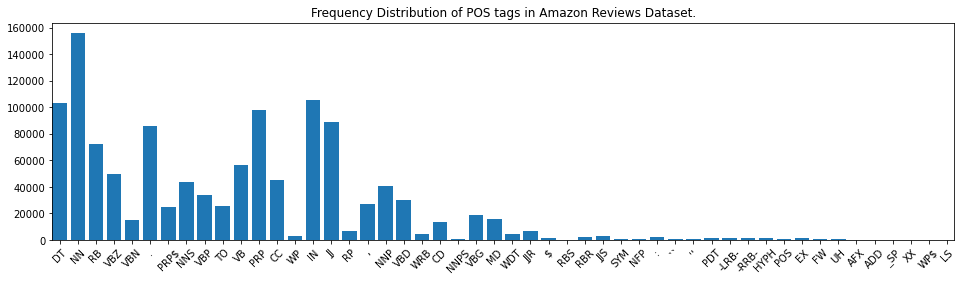

In [ ]:
#plot counter as bar plot to show frequency distribution of POS tags in dataset
freq_dist = Counter(tags)
plt.bar(freq_dist.keys(), freq_dist.values())
plt.xticks(rotation=45)
plt.title("Frequency Distribution of POS tags in Amazon Reviews Dataset.")
#solution from stack overflow starts here
# I needed a way to make the plot wider, keeping font size readable and spacing the ticks
# on the X axis so the labels weren't touching
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*35+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
# solution from ImportanceOfBeingEarnest (2017)



### NER Top K Most Frequent

In [ ]:
# Most common NER labels:
print(Counter(ner_labels))

Counter({'ORG': 13751, 'CARDINAL': 6222, 'DATE': 6035, 'PERSON': 3347, 'ORDINAL': 2108, 'LOC': 1724, 'GPE': 1602, 'MONEY': 1428, 'TIME': 965, 'WORK_OF_ART': 595, 'FAC': 468, 'PRODUCT': 294, 'EVENT': 287, 'QUANTITY': 283, 'NORP': 254, 'PERCENT': 111, 'LAW': 28, 'LANGUAGE': 17})


As shown by the Counter object in the output above, the most common NER label is ORG with 13751 occurrences.

### Sentiment Analysis: Customer Reviews
Workflow:
- Text normalisation
- Tokenisation
- Logistic Regression model

I decided to lemmatize but not stem my words during normalization because I wanted to retain more meaning.

In [ ]:
# Text normalisation
def normalize(text):
    """Takes a string and cleans it by expanding contractions and removing punctuation,
    digits, newlines, excess spaces, stop words, and words with a length less than 3.
    Returns clean string."""

    #print("Cleaning text...")

    # Expand contractions
    text = contractions.fix(text, slang=False)

    # Remove punctuation and digits
    digits = r'[0-9]'
    text = re.sub(digits, '', text)
    for punct in list(string.punctuation):
        if punct in text:
            text = text.replace(punct, "")

    # Make text lowercase and replace newline characters
    text = text.lower().replace("\n", " ")

    # Remove any word with a length of < 3 (all 2 letter words in this context may be
    # treated as stop words)
    # This also removes excess spaces
    text_list = text.split()
    new_list = []
    stop_words = list(ENGLISH_STOP_WORDS)
    for word in text_list:
        if len(word) > 2:
            new_list.append(word)

    # Remove stop words
    #print("Removing stop words. This may take a couple of minutes, please wait...")
    for word in stop_words:
        while word in new_list:
            new_list.remove(word)
    text = " ".join(new_list)

    # Tokenization
    #tokens = nltk.word_tokenize(text)

    # Lemmatization
    #print("Lemmatizing...")
    # Process the text using spaCy (Credit to this solution to geeksforgeeks)
    doc = sp(text)

    # Extract lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Join the lemmatized tokens into a sentence
    lemmatized_text = ' '.join(lemmatized_tokens)

    #print("Preprocessing complete!")
    return lemmatized_text

In [ ]:
# Text normalization and tokenization demo
print(normalize("This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease."))

product far disappointed child love use like ability monitor control content ease


In [ ]:
# Create new column for normalized reviews
review_tokens_column = []

count = 0
start = time.time()
# For each review in reviews txt
#iterate through each review
for index, row in amzn_df.loc[:, ["reviews.text"]].iterrows():
    review_tokens_column.append(normalize(row["reviews.text"]))
    # time & entries
    sec = time.time() - start
    count = count + 1
    if count%10000==0:
         print("Time elapsed:", (timedelta(seconds=sec)), "Entries Complete:", count)

print("Process complete.")

Time elapsed: 0:00:46.433378 Entries Complete: 10000
Time elapsed: 0:01:33.283525 Entries Complete: 20000
Time elapsed: 0:02:21.926600 Entries Complete: 30000
Process complete.


In [ ]:
#amzn_df = amzn_df.drop(["reviews.tokens"], axis=1)
amzn_df["reviews.tokens"] = review_tokens_column
amzn_df.head()

,reviews.doRecommend,reviews.text,pos.tags,ner.labels,reviews.tokens
0,1.0,This product so far has not disappointed. My c...,"{This: 'DT', product: 'NN', so: 'RB', far: 'RB...",{},product far disappointed child love use like a...
1,1.0,great for beginner or experienced person. Boug...,"{great: 'JJ', for: 'IN', beginner: 'NN', or: '...",{},great beginner experience person buy gift love
2,1.0,Inexpensive tablet for him to use and learn on...,"{Inexpensive: 'JJ', tablet: 'NN', for: 'IN', h...",{(Skype): 'ORG'},inexpensive tablet use learn step nabi thrille...
3,1.0,I've had my Fire HD 8 two weeks now and I love...,"{I: 'PRP', 've: 'VBP', had: 'VBN', my: 'PRP$',...","{(8, two, weeks): 'DATE', (SHINES): 'ORG', (12...",week love tablet great valuewe prime members t...
4,1.0,I bought this for my grand daughter when she c...,"{I: 'PRP', bought: 'VBD', this: 'DT', for: 'IN...","{(Amazon): 'ORG', (64gig): 'CARDINAL', (hundre...",buy grand daughter come visit set user enter a...


In [ ]:
# The reviews.doRecommend contains some empty values so I'll drop those
amzn_df.dropna(subset=['reviews.doRecommend'], inplace=True)

In [ ]:
amzn_df.head()

,reviews.doRecommend,reviews.text,pos.tags,ner.labels,reviews.tokens
0,1.0,This product so far has not disappointed. My c...,"{This: 'DT', product: 'NN', so: 'RB', far: 'RB...",{},product far disappointed child love use like a...
1,1.0,great for beginner or experienced person. Boug...,"{great: 'JJ', for: 'IN', beginner: 'NN', or: '...",{},great beginner experience person buy gift love
2,1.0,Inexpensive tablet for him to use and learn on...,"{Inexpensive: 'JJ', tablet: 'NN', for: 'IN', h...",{(Skype): 'ORG'},inexpensive tablet use learn step nabi thrille...
3,1.0,I've had my Fire HD 8 two weeks now and I love...,"{I: 'PRP', 've: 'VBP', had: 'VBN', my: 'PRP$',...","{(8, two, weeks): 'DATE', (SHINES): 'ORG', (12...",week love tablet great valuewe prime members t...
4,1.0,I bought this for my grand daughter when she c...,"{I: 'PRP', bought: 'VBD', this: 'DT', for: 'IN...","{(Amazon): 'ORG', (64gig): 'CARDINAL', (hundre...",buy grand daughter come visit set user enter a...


In [ ]:
X = amzn_df["reviews.tokens"]  # features
y = amzn_df["reviews.doRecommend"] # label

In [ ]:
# Split dataset into 80 train, 20 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorizer
vectorizer = CountVectorizer().fit(X_train)
train_v = vectorizer.transform(X_train)
test_v = vectorizer.transform(X_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X=train_v, y=y_train)

# I had to set max_iter to avoid a warning that kept being output

LogisticRegression(max_iter=1000)

In [ ]:
# Classification report
predictions = model.predict(X=test_v)
report = classification_report(y_test, predictions)

print("Number of features: {:6d}".format(len(vectorizer.get_feature_names_out())))
print("Training accuracy:  {:.2%}".format(model.score(train_v, y_train)))
print("Test accuracy:      {:.2%}".format(model.score(test_v, y_test)))
print(report)
print()

Number of features:  12474
Training accuracy:  97.66%
Test accuracy:      95.99%
              precision    recall  f1-score   support

         0.0       0.51      0.25      0.34       277
         1.0       0.97      0.99      0.98      6537

    accuracy                           0.96      6814
   macro avg       0.74      0.62      0.66      6814
weighted avg       0.95      0.96      0.95      6814




Since the question doesn't specify to evaluate the performance or perform any tuning, I will move on to using RNN for sentiment analysis.

### Sentiment Analysis: Movie Reviews
 Workflow:
- Text normalisation
- Tokenisation
- Text embedding (word2vec)
- Building an RNN (Bidirectional LSTM)
- Performance Evaluation

### Data

The data used for this portion is a movie reviews dataset available here: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

The File I will use is movie.csv.

In [ ]:
# read the data in
movies_df = pd.read_csv("movie.csv")
movies_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


Even when running this part of the notebook in isolation, with all applications closed, and deleting variables as I no longer needed them, my laptop was hitting 100% memory and crashing whenever I tried to actually train the RNN. So, I had to cut the dataset by 25,000 items, reduce the word2vec vector size, and decrease number of neurons, and decrease batch size and tweak a few other parameters.

In [ ]:
movies_df.drop(movies_df.tail(25000).index,
        inplace = True)

In [ ]:
len(movies_df)

15000

The function below is a modified version of my previous normalization function which tokenizes the reviews into lists of tokens.

In [ ]:
def normalize2vec(text):
    #print("Cleaning text...")

    # Expand contractions
    text = contractions.fix(text, slang=False)

    # Remove punctuation and digits
    digits = r'[0-9]'
    text = re.sub(digits, '', text)
    for punct in list(string.punctuation):
        if punct in text:
            text = text.replace(punct, "")

    # Make text lowercase and replace newline characters
    text = text.replace("\n", " ")

    # Tokenization
    tokens = nltk.word_tokenize(text)

    #print("Preprocessing complete!")
    return tokens

In [ ]:
# List to store tokens
review_tokens = []

count = 0
start = time.time()
#iterate through each review
for index, row in movies_df.loc[:, ["text"]].iterrows():
    review_tokens.append(normalize2vec(row["text"]))
    # time & entries
    sec = time.time() - start
    count = count + 1
    if count%10000==0:
         print("Time elapsed:", (timedelta(seconds=sec)), "Entries Complete:", count)

print("Process complete.")

Time elapsed: 0:00:05.784805 Entries Complete: 10000
Process complete.


In [ ]:
print(review_tokens[8])
print(len(review_tokens))

['It', 'may', 'be', 'the', 'remake', 'of', 'Autumns', 'Tale', 'after', 'eleven', 'years', 'as', 'the', 'director', 'Mabel', 'Cheung', 'claimed', 'Mabel', 'employs', 'rock', 'music', 'as', 'the', 'medium', 'in', 'this', 'movie', 'to', 'express', 'her', 'personal', 'attitude', 'to', 'life', 'in', 'which', 'love', 'desire', 'and', 'the', 'consequential', 'frustration', 'play', 'significantly', 'crucial', 'roles', 'Rock', 'music', 'may', 'not', 'be', 'the', 'best', 'vehicle', 'to', 'convey', 'the', 'profound', 'sentiment', 'and', 'yet', 'it', 'is', 'not', 'too', 'inappropriate', 'to', 'utilize', 'it', 'as', 'the', 'life', 'of', 'underground', 'rock', 'musicians', 'is', 'bitterly', 'more', 'intense', 'than', 'an', 'ordinary', 'one', 'The', 'director', 'focuses', 'on', 'the', 'depiction', 'of', 'subtle', 'affection', 'and', 'ultimate', 'vanity', 'of', 'life', 'rather', 'than', 'mere', 'rock', 'music', 'The', 'love', 'between', 'father', 'and', 'son', 'lovers', 'and', 'friends', 'is', 'delica

In [ ]:
# Text embedding with Word2Vec
vec_model = Word2Vec(review_tokens,
                 min_count=3,   # Ignore words that appear less than this
                 vector_size=100,      # Dimensionality of word embeddings
                 workers=3,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 epochs=30)     # Number of epochs training over corpus

In [ ]:
# finding vocab size from my tokens
# right now they are a list of lists so I need to make it a single list of tokens
all_tokens = [token for sublist in review_tokens for token in sublist]

# Calculate the frequency of each token
token_counts = Counter(all_tokens)

# index mapping
word_index = {word: i+1 for i, (word, _) in enumerate(token_counts.items())}

# calculate vocab size + 1 for padding
vocab_size = len(word_index) + 1
print(vocab_size)

106839


To use my Word2Vec model with my RNN for sentiment analysis, I will need to create an embedding matrix to be used in my RNN's embedding layer.

In [ ]:
# create embedding matrix
embedding_dim = vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in vec_model.wv:
        embedding_vector = vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Tokens to index and padding
sequences = [[word_index.get(token, 0) for token in sublist] for sublist in review_tokens]

# pad the sequences
max_length = max(len(s) for s in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [ ]:
# Number of neurons/ nodes in hidden state
# Reduce if too inefficient on computational resources
lstm_out = 50

# Create new model
model = tf.keras.Sequential()

# Embedding layer with Word2Vec model/ embedding matrix
model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))

# Dropout can be used to prevent overfitting (performing well on training but poorly on new data)
# Dropout will turn off some neurons in the neural network in each epoch
model.add(tf.keras.layers.SpatialDropout1D(0.4)) # %40 of neurons off during each epoch

# Bidirectional RNN: an additional RNN starts at the end of the sequence and goes the other
# direction. Two RNNs in total.
# included LSTM
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, recurrent_dropout=0.2)))

# 2 because bidirectional, activation function is softmax
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# cat cross entropy is loss function, Adam is an optimizer
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

2024-03-09 02:40:36.094227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-09 02:40:36.094250: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-09 02:40:36.094268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (budgie-sama): /proc/driver/nvidia/version does not exist
2024-03-09 02:40:36.094473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2473, 100)         10683900  
                                                                 
 spatial_dropout1d (SpatialD  (None, 2473, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100)              60400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 10,744,502
Trainable params: 60,602
Non-trainable params: 10,683,900
_________________________________________________________________


In [ ]:
# Create Y out of binary data (labels)
y = pd.get_dummies(movies_df['label'])
result_dict = {0: 'Negative', 1: 'Positive'}
y_arr = np.vectorize(result_dict.get)(Y.columns)


In [ ]:
y = y.values

In [ ]:
X = padded_sequences

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


In [ ]:
# In an attempt to save memory, I'm clearing this large variable as I don't need it anymore
del review_tokens

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10050, 2473) (10050, 2)
(4950, 2473) (4950, 2)


In [ ]:
# Train the model
# Small batch size for smaller data (and less memory)
# Only 3 epochs due to time constraints
model.fit(X_train, y_train, epochs=3, batch_size=50, verbose=2)

Epoch 1/3
201/201 - 292s - loss: 0.6750 - accuracy: 0.5754 - 292s/epoch - 1s/step
Epoch 2/3
201/201 - 297s - loss: 0.5937 - accuracy: 0.6869 - 297s/epoch - 1s/step
Epoch 3/3
201/201 - 300s - loss: 0.5448 - accuracy: 0.7370 - 300s/epoch - 1s/step


In [ ]:
# Performance evaluation
score, acc = model.evaluate(X_test, y_test, verbose=2, batch_size=25)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

198/198 - 36s - loss: 0.4589 - accuracy: 0.8022 - 36s/epoch - 183ms/step
score: 0.46
acc: 0.80


## Recommender Systems

 #### Introduction
   A recommender system is a machine-learning model which aims to recommend a product to a person or group of people based on information about them and the product. Recommender systems can find patterns in consumer behaviour, and are the systems behind the personalised adverts we see everywhere online nowadays.


#### Three Models of Recommender Systems

   In their 2021 paper, Zhang, Liu and Jin describe three main models of recommender system, each with their own strengths and weaknesses: content-based, collaborative filter-based, and knowledge-based. There are other models such as utility-based, demographic-based and hybrid-based (Fayyaz, et al. 2020), but for the sake of brevity the three aforementioned will be explored here.

   Content-based recommender systems utilize item descriptions to predict utility based on a user's profile. They extract item properties and compare them with the user's profile to form recommendations. Advantages include user independence, solving the new item cold-start problem (where recommendations are challenging for new items lacking sufficient user interaction data), and providing transparent recommendations. However, they face limitations such as the new user problem (where new users do not have enough data about them) and overspecialization in recommendations.
   
   Collaborative filtering-based recommender systems infer item utility from other users' ratings. They employ memory-based and model-based techniques. Memory-based CF calculates similarity between users/items using nearest neighbor algorithms, while model-based CF uses machine learning methods like matrix factorization. CF addresses the cold-start problem but suffers from scalability issues and recommendation coverage limitations.

   Knowledge-based recommender systems rely on existing knowledge or rules about user needs and item functions. They retain a knowledge base from which recommendations are derived. Case-based reasoning is a common technique. While valuable in domains like house sales and health decision support, setting up and managing the knowledge base incurs high costs despite advantages such as no new item/user problems and user-constraint flexibility.
                                                     
----------------------------------------------------------------------------------------   (Zhang, Liu & Jin, 2021)
                                                               
   
   
#### Recommender System Algorithms & Techniques

Many different algorithms and machine learning techniques can be employed when creating, training and deploying recommender systems. The 2021 paper by Zhang, Liu and Jin contains this figure, showing a few of them and their main application areas.
![image.png](attachment:image.png)
Fig.1 "AI Areas and Techniques" (Zhang, Liu & Jin, 2021).


   One example of a widely used family of techniques are that of graph neural network (GNN) based techniques. Graph Neural Networks (GNNs) are utilized in recommender systems due to there being a prevalent graph structure in the data used by recommender systems. GNN-based models can model heterogeneous data types in recommender systems, including user-item interactions and structured external information like social relationships among users and item knowledge graphs. GNNs have demonstrated remarkable success in academic research and industrial applications, outperforming previous methods and achieving state-of-the-art results across various recommendation tasks, including session-based, point-of-interest, group, multimedia, and bundle recommendations (Wu et al., 2022).

   
   

## References
ImportanceOfBeingEarnest (2017) *How to change spacing between ticks*. Stackoverflow. Available at: https://stackoverflow.com/questions/44863375/how-to-change-spacing-between-ticks

Yash_R (2024) *Python Lemmatization with NLTK*. Geeks for Geeks. Available at: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

Zhang, Q., Lu, J. & Jin, Y. *Artificial intelligence in recommender systems.* Complex Intelligence Systems, 7, 439–457. Available at: https://doi.org/10.1007/s40747-020-00212-whttps://link.springer.com/article/10.1007/s40747-020-00212-w

Fayyaz, Z., Ebrahimian, M., Nawara, D., Ibrahim, A. & Kashef, R. (2020) *Recommendation Systems: Algorithms, Challenges, Metrics, and Business Opportunities.* Applied Sciences, 10, 7748. Available at: https://doi.org/10.3390/app10217748

Wu, S., Sun, F., Zhang, W., Xie, X. & Cui, B. (2022) *Graph Neural Networks in Recommender
Systems: A Survey.* ACM Computing Surveys, 55(5), 97. Available at:
https://doi.org/10.1145/3535101